<a href="https://colab.research.google.com/github/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/7506_R_TP2_GRUPO09_ENTREGA_N3(Ensambles).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración inicial

Importamos las bibliotecas necesarias.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold
from joblib import dump, load 

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline 

from sklearn.metrics import (
    confusion_matrix,
    recall_score, 
    accuracy_score, 
    f1_score,
    mean_squared_error,
    r2_score,
    mean_absolute_error
)

from xgboost import XGBRegressor

!pip install xgboost

np.random.seed(1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Funciones útiles

In [18]:
def graficar_matriz_de_confusion(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize = (12, 10))
    sns.heatmap(
        cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="GnBu", fmt="g"
    )
    plt.title("Matriz de confusión")
    plt.xlabel("Predichos")
    plt.ylabel("Verdaderos")
    plt.show()

def imprimir_metricas_de_clasificacion(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print("\nMétricas de clasificación\n")
    print("Accuracy: " + str(accuracy))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))

def imprimir_metricas_de_regresion(target_test, precios_predichos):
    # Error cuadrático medio
    mse = mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=True
    )

    # Raíz del error cuadrático medio
    rmse = mean_squared_error(
        y_true=target_test, y_pred=precios_predichos, squared=False
    )

    # Score R2
    r2 = r2_score(target_test, precios_predichos)

    print("\nMétricas de regresión\n")
    print(f"El error (mse) de test es: {mse}")
    print(f"El error (rmse) de test es: {rmse}")
    print(f"El score R2 es: {r2}")

## Modelos

Importamos los modelos generados en el TP1.

In [42]:
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/arbolDeDecision.joblib -O arbol_de_decision.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/randomForest.joblib -O random_forest.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/regresionLogistica.joblib -O regresion_logistica.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/knn.joblib -O knn.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/xgb.joblib -O xgb.joblib
!wget https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/gradientBoosting.joblib -O gradient_boosting.joblib

--2022-12-07 16:43:26--  https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/raw/main/tp2/arbolDeDecision.joblib
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuSanchez02/7506R-2c2022-GRUPO09/main/tp2/arbolDeDecision.joblib [following]
--2022-12-07 16:43:27--  https://raw.githubusercontent.com/ManuSanchez02/7506R-2c2022-GRUPO09/main/tp2/arbolDeDecision.joblib
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 908544 (887K) [application/octet-stream]
Saving to: ‘arbol_de_decision.joblib’

arbol_de_decision.j 100%[===================>] 887.25K  --.-KB/s    in 0.008s  

2022-12-07 16:43:27 (115 

In [43]:
# Modelos clasificación
arbol_de_decision = load("arbol_de_decision.joblib")
random_forest = load("random_forest.joblib")
regresion_logistica = load("regresion_logistica.joblib")

# Modelos regresión
knn = load("knn.joblib")
xgboost = load("xgb.joblib")
gradient_boost = load("gradient_boosting.joblib")

[16:43:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Datasets

Importamos los datasets con los que vamos a trabajar.

In [44]:
clasificacion_train_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_feature.csv?raw=true")
clasificacion_train_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_train_target.csv?raw=true")
clasificacion_test_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_feature.csv?raw=true")
clasificacion_test_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/clasificacion_test_target.csv?raw=true")
regresion_train_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_feature.csv?raw=true")
regresion_train_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_train_target.csv?raw=true")
regresion_test_feature = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_feature.csv?raw=true")
regresion_test_target = pd.read_csv("https://github.com/ManuSanchez02/7506R-2c2022-GRUPO09/blob/main/tp2/datasets/regresion_test_target.csv?raw=true")


In [45]:
def preparar_dataset(dataset):
  dataset.drop("Unnamed: 0", axis = 1, inplace=True)
  dataset.drop("id", axis = 1, inplace=True)
  return dataset

def preparar_target(target):
  target.drop("Unnamed: 0", axis = 1, inplace=True)
  return target

clasificacion_train_feature = preparar_dataset(clasificacion_train_feature)
clasificacion_test_feature = preparar_dataset(clasificacion_test_feature)
regresion_train_feature = preparar_dataset(regresion_train_feature)
regresion_test_feature = preparar_dataset(regresion_test_feature)

clasificacion_train_target = preparar_target(clasificacion_train_target)
clasificacion_test_target = preparar_target(clasificacion_test_target)
regresion_train_target = preparar_target(regresion_train_target)
regresion_test_target = preparar_target(regresion_test_target)

# Voting

Convertimos las categorías del target de clasificación en categorías numéricas para que los modelos trabajen con los mismos datos y escalamos el modelo de regresión logísitca para que performe mejor.

In [23]:
label_encoder = preprocessing.LabelEncoder()
clasificacion_train_target = label_encoder.fit_transform(clasificacion_train_target)
clasificacion_test_target = label_encoder.transform(clasificacion_test_target)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
regresion_logistica_escalado = Pipeline([("ss", StandardScaler()), ("rl", regresion_logistica)])

Creamos un ensamble de votación.

In [25]:
#vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest), ('rl', regresion_logistica)], voting = 'soft') Score 0.66
#vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest)], voting = 'soft') Score 0.64
#vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest), ('rle', regresion_logistica_escalado)], voting = 'soft') #Score 0.65
vot_clf = VotingClassifier(estimators = [('add', arbol_de_decision), ('rf', random_forest), ('rle', regresion_logistica_escalado)], voting = 'hard') #Score 0.685

Entrenamos el modelo.

In [26]:
vot_clf.fit(clasificacion_train_feature, clasificacion_train_target)

VotingClassifier(estimators=[('add',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=900,
                                                     min_samples_leaf=8,
                                                     random_state=0)),
                             ('rf',
                              RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                                 estimator=RandomForestClassifier(),
                                                 n_iter=5,
                                                 param_distributions={'criterion': ['gini',
                                                                                    'entropy'],
                                                                      'min_samples_leaf': [1,
                                                                                           2,
      

Evaluamos el modelo con los datos de train para ver qué tan bien se entrenó.

In [27]:
labels=["bajo","medio","alto"]

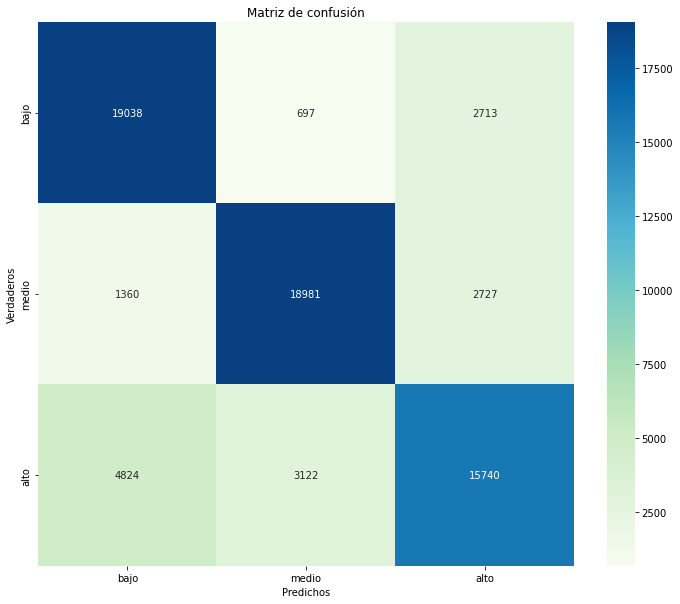


Métricas de clasificación

Accuracy: 0.776841709777174
Recall: 0.776841709777174
F1 score: 0.7751395914844152


In [28]:
clasificacion_pred_target = vot_clf.predict(clasificacion_train_feature)
graficar_matriz_de_confusion(clasificacion_train_target, clasificacion_pred_target, labels)
imprimir_metricas_de_clasificacion(clasificacion_train_target, clasificacion_pred_target)

Evaluamos en el conjunto de test y vemos que tiene buenos resultados.

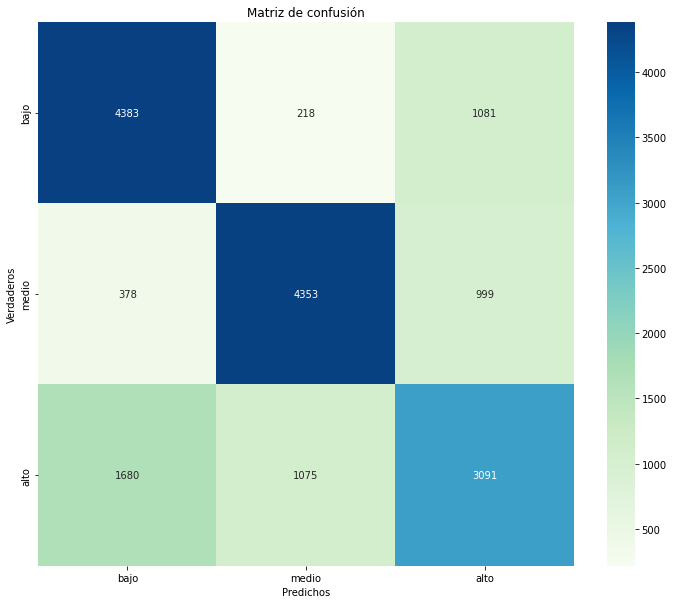


Métricas de clasificación

Accuracy: 0.6853053656275351
Recall: 0.6853053656275351
F1 score: 0.6822408562158239


In [30]:
clasificacion_pred_target = vot_clf.predict(clasificacion_test_feature)
graficar_matriz_de_confusion(clasificacion_test_target, clasificacion_pred_target, labels)
imprimir_metricas_de_clasificacion(clasificacion_test_target, clasificacion_pred_target)

# Stacking

Creamos el ensamble a partir de los modelos de regresión generados en el TP1.

In [54]:
# Modelos Base
base_models = [('knn', knn),
               ('xgb', xgboost),
               ('gb', gradient_boost)]

# Creamos el ensamble
stacking_model = StackingRegressor(estimators=base_models, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

Entrenamos el modelo de stacking.

In [55]:
stacking_model.fit(regresion_train_feature, regresion_train_target)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_stacking.py:758: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:26:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[17:32:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


StackingRegressor(cv=5,
                  estimators=[('knn',
                               KNeighborsRegressor(n_neighbors=19,
                                                   weights='distance')),
                              ('xgb',
                               XGBRegressor(learning_rate=0.07, max_depth=12,
                                            min_child_weight=6, missing=nan,
                                            n_estimators=500)),
                              ('gb',
                               GradientBoostingRegressor(learning_rate=0.625,
                                                         max_depth=6,
                                                         n_estimators=65,
                                                         random_state=0))],
                  passthrough=True, verbose=2)

Medimos la performance con los datos de train.

In [56]:
regresion_pred_target = stacking_model.predict(regresion_train_feature)
imprimir_metricas_de_regresion(regresion_train_target, regresion_pred_target)


Métricas de regresión

El error (mse) de test es: 354372369.6045771
El error (rmse) de test es: 18824.780731912313
El score R2 es: 0.9669615972519024


Calculamos con los datos de test.

In [57]:
regresion_pred_target = stacking_model.predict(regresion_test_feature)
imprimir_metricas_de_regresion(regresion_test_target, regresion_pred_target)


Métricas de regresión

El error (mse) de test es: 1216914744.9436228
El error (rmse) de test es: 34884.305137749594
El score R2 es: 0.8854469959281017


## Conclusiones

Los resultados del voting no mejoraron a los resultados de los modelos por separado. Esto puede deberse a que RandomForest ya es un ensamble de voting, por lo que hacer un ensamble nuevo con un RandomForest y un DecisionTree no aporta mucho. Quizás agregar modelos más diversos, como KNN o XGBoost hubiera mejorado las métricas.

Por otro lado, el resultado del stacking es muy bueno, similar al obtenido con los modelos por separado. Analizándolo, podemos suponer que el estimador final eligió XGBoost como mejor modelo.

En el TP1, los scores R2 sobre los datos de test fueron:

  - XGBoost: 0.8875645071859526
  - GradientBoost: 0.8467735847628741
  - KNN: 0.7906024537502832